In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests as gct
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/block_chain'
os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
blocks = pd.read_csv('blocks.csv')
blocks

,block_number,date_time,size,gas_limit,gas_used,transaction_count
0,13432144,2021-10-17 00:00,137337,30000000,29989466,395
1,13432145,2021-10-17 00:00,152246,30000000,29991025,350
2,13432146,2021-10-17 00:00,86607,30000000,18441422,182
3,13432147,2021-10-17 00:01,25291,29970705,5773702,44
4,13432148,2021-10-17 00:01,131885,29999972,26063490,337
...,...,...,...,...,...,...
5512332,18944476,2024-01-05 23:59,78795,30000000,29997771,177
5512333,18944477,2024-01-05 23:59,76583,30000000,15833654,168
5512334,18944478,2024-01-05 23:59,98769,30000000,11467724,113
5512335,18944479,2024-01-05 23:59,192081,30000000,16086918,114


In [ ]:
trans = pd.read_csv('./transcations.csv')
trans

,block_number,date_time,total_volume
0,13432144,2021-10-17 00:00,683.326345
1,13432145,2021-10-17 00:00,199.728254
2,13432146,2021-10-17 00:00,3046.571869
3,13432147,2021-10-17 00:01,142.073001
4,13432148,2021-10-17 00:01,320.793757
...,...,...,...
5452703,18944476,2024-01-05 23:59,44.329264
5452704,18944477,2024-01-05 23:59,58.734846
5452705,18944478,2024-01-05 23:59,8.849958
5452706,18944479,2024-01-05 23:59,16.469168


In [ ]:
df = pd.merge(blocks, trans, on=['block_number','date_time'], how='left')
df

,block_number,date_time,size,gas_limit,gas_used,transaction_count,total_volume
0,13432144,2021-10-17 00:00,137337,30000000,29989466,395,683.326345
1,13432145,2021-10-17 00:00,152246,30000000,29991025,350,199.728254
2,13432146,2021-10-17 00:00,86607,30000000,18441422,182,3046.571869
3,13432147,2021-10-17 00:01,25291,29970705,5773702,44,142.073001
4,13432148,2021-10-17 00:01,131885,29999972,26063490,337,320.793757
...,...,...,...,...,...,...,...
5512332,18944476,2024-01-05 23:59,78795,30000000,29997771,177,44.329264
5512333,18944477,2024-01-05 23:59,76583,30000000,15833654,168,58.734846
5512334,18944478,2024-01-05 23:59,98769,30000000,11467724,113,8.849958
5512335,18944479,2024-01-05 23:59,192081,30000000,16086918,114,16.469168


In [ ]:
df.fillna(0, inplace=True)
df.sort_values(by='block_number', inplace=True)
df.drop(columns='block_number', inplace=True)
df['date_time'] = pd.to_datetime(blocks['date_time'].str[:16])
df.set_index('date_time', inplace=True)
by_day = df.resample('D').mean()
by_day.columns = ['avg_size','avg_gas_limit','avg_gas_used','avg_transaction_count', 'avg_transferred_eth']

In [ ]:
# 1-period lag
by_day['avg_gas_used_lag1'] = by_day['avg_gas_used'].shift(1)
by_day['avg_transaction_count_lag1'] = by_day['avg_transaction_count'].shift(1)

# rolling average of the past 7 days
by_day['avg_gas_used_rolling6'] = by_day['avg_gas_used'].rolling(window=7).mean()
by_day['vg_transaction_count_rolling6'] = by_day['avg_transaction_count'].rolling(window=7).mean()

by_day.dropna(inplace=True)

In [ ]:
by_day.reset_index(inplace=True)
by_day.rename(columns={'index': 'date_time'}, inplace=True)
by_day

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6
0,2021-10-23,72291.795054,3.002474e+07,1.545689e+07,194.576087,200.611032,1.545113e+07,195.920137,1.544343e+07,192.512938
1,2021-10-24,71576.064318,3.002441e+07,1.544829e+07,198.350684,151.453354,1.545689e+07,194.576087,1.544383e+07,195.248929
2,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841
3,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193
4,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949
...,...,...,...,...,...,...,...,...,...,...
800,2024-01-01,172255.595047,2.999972e+07,1.511294e+07,154.983115,132.993246,1.510753e+07,148.795853,1.509921e+07,156.574667
801,2024-01-02,175613.360713,2.999970e+07,1.509108e+07,158.474726,208.660422,1.511294e+07,154.983115,1.509829e+07,156.882294
802,2024-01-03,162254.063824,2.999971e+07,1.511663e+07,153.208024,235.214576,1.509108e+07,158.474726,1.510088e+07,155.903871
803,2024-01-04,159506.507155,2.999970e+07,1.507971e+07,156.646044,200.169137,1.511663e+07,153.208024,1.509890e+07,154.522298


In [ ]:
#In order to predict tomorrow we need to lag it such that we can have tomorrow's gas used in today's row
by_day['avg_gas_used_tom'] = by_day['avg_gas_used'].shift(-1)
by_day.dropna(inplace=True)
by_day

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,avg_gas_used_tom
0,2021-10-23,72291.795054,3.002474e+07,1.545689e+07,194.576087,200.611032,1.545113e+07,195.920137,1.544343e+07,192.512938,1.544829e+07
1,2021-10-24,71576.064318,3.002441e+07,1.544829e+07,198.350684,151.453354,1.545689e+07,194.576087,1.544383e+07,195.248929,1.545153e+07
2,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,1.544777e+07
3,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,1.544270e+07
4,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,1.544423e+07
...,...,...,...,...,...,...,...,...,...,...,...
799,2023-12-31,166562.542525,2.999978e+07,1.510753e+07,148.795853,123.778499,1.509966e+07,153.473973,1.509711e+07,156.602490,1.511294e+07
800,2024-01-01,172255.595047,2.999972e+07,1.511294e+07,154.983115,132.993246,1.510753e+07,148.795853,1.509921e+07,156.574667,1.509108e+07
801,2024-01-02,175613.360713,2.999970e+07,1.509108e+07,158.474726,208.660422,1.511294e+07,154.983115,1.509829e+07,156.882294,1.511663e+07
802,2024-01-03,162254.063824,2.999971e+07,1.511663e+07,153.208024,235.214576,1.509108e+07,158.474726,1.510088e+07,155.903871,1.507971e+07


In [ ]:
#Interest Rates CSV
rates = pd.read_csv('long_term_rates_2000_2023.csv')
rates.drop('Extrapolation Factor', axis=1, inplace=True)

In [ ]:
rates['Date'] = pd.to_datetime(rates['Date'])
rates.rename(columns={'LT COMPOSITE (>10 Yrs)': 'Interest_rate'}, inplace=True)
rates

<ipython-input-69-5c2dd521ba98>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rates['Date'] = pd.to_datetime(rates['Date'])


,Date,Interest_rate,TREASURY 20-Yr CMT
0,2023-12-29,4.15,4.20
1,2023-12-28,4.09,4.14
2,2023-12-27,4.06,4.10
3,2023-12-26,4.17,4.20
4,2023-12-22,4.18,4.21
...,...,...,...
5998,2000-01-07,6.77,6.82
5999,2000-01-06,6.81,6.86
6000,2000-01-05,6.89,6.95
6001,2000-01-04,6.78,6.84


In [ ]:
df = pd.merge(by_day, rates, how='right', left_on='date_time', right_on='Date')
#df.set_index('date_time', inplace=True)
df.sort_values(by='Date', inplace=True)
df.dropna(inplace=True)
df.drop('Date', axis=1, inplace=True)

df

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,avg_gas_used_tom,Interest_rate,TREASURY 20-Yr CMT
545,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,1.544777e+07,2.03,2.07
544,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,1.544270e+07,1.99,2.03
543,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,1.544423e+07,1.89,1.93
542,2021-10-28,67421.642166,3.002487e+07,1.544423e+07,235.721286,282.674664,1.544270e+07,215.997478,1.544893e+07,207.529184,1.544402e+07,1.92,1.98
541,2021-10-29,64129.096891,3.002177e+07,1.544402e+07,228.695509,468.680630,1.544423e+07,235.721286,1.544792e+07,212.211380,1.544558e+07,1.91,1.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2023-12-22,157152.837050,2.999968e+07,1.508977e+07,169.080353,308.952772,1.508273e+07,173.852604,1.511023e+07,162.894603,1.510166e+07,4.18,4.21
3,2023-12-26,168868.433772,2.999971e+07,1.509749e+07,156.321339,232.276084,1.509825e+07,155.177878,1.509810e+07,163.901048,1.509850e+07,4.17,4.20
2,2023-12-27,173258.384778,2.999977e+07,1.509850e+07,160.056978,236.451383,1.509749e+07,156.321339,1.509531e+07,161.741618,1.509356e+07,4.06,4.10
1,2023-12-28,150761.920174,2.999976e+07,1.509356e+07,166.317059,257.944678,1.509850e+07,160.056978,1.509686e+07,160.665112,1.508478e+07,4.09,4.14


In [ ]:
# download cryptocurrency data
btc = yf.download('BTC-USD', start='2021-08-06', end='2023-12-31')
eth = yf.download('ETH-USD', start='2021-08-06', end='2023-12-29')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
btc.reset_index(inplace=True)
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-06,40865.867188,43271.660156,39932.179688,42816.500000,42816.500000,38226483046
1,2021-08-07,42832.796875,44689.859375,42618.566406,44555.800781,44555.800781,40030862141
2,2021-08-08,44574.437500,45282.351562,43331.910156,43798.117188,43798.117188,36302664750
3,2021-08-09,43791.925781,46456.832031,42848.687500,46365.402344,46365.402344,38734079049
4,2021-08-10,46280.847656,46637.988281,44705.554688,45585.031250,45585.031250,33546019517


In [ ]:
eth.reset_index(inplace=True)
eth.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-06,2827.503418,2944.903320,2727.792725,2890.941650,2890.941650,26528577879
1,2021-08-07,2891.707520,3170.229736,2868.535645,3157.238770,3157.238770,33081467129
2,2021-08-08,3161.232666,3184.604004,2951.747314,3013.732666,3013.732666,28433638008
3,2021-08-09,3012.885742,3185.701172,2900.926025,3167.856201,3167.856201,31983260936
4,2021-08-10,3163.050049,3228.940674,3059.229004,3141.691162,3141.691162,27605221710


In [ ]:
#Merge df & Eth Together
eth_renamed = eth.rename(columns={col: col + '_eth' if col != 'Date' else col for col in eth.columns})

df_plus_eth = pd.merge(df, eth_renamed, how='left', left_on='date_time', right_on='Date')

df_plus_eth

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,avg_gas_used_tom,Interest_rate,TREASURY 20-Yr CMT,Date,Open_eth,High_eth,Low_eth,Close_eth,Adj Close_eth,Volume_eth
0,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,1.544777e+07,2.03,2.07,2021-10-25,4084.425781,4236.666992,4072.034668,4217.876953,4217.876953,1.599573e+10
1,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,1.544270e+07,1.99,2.03,2021-10-26,4217.337891,4289.131348,4106.823730,4131.102051,4131.102051,1.715771e+10
2,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,1.544423e+07,1.89,1.93,2021-10-27,4132.173340,4299.152832,3930.257324,3930.257324,3930.257324,2.621953e+10
3,2021-10-28,67421.642166,3.002487e+07,1.544423e+07,235.721286,282.674664,1.544270e+07,215.997478,1.544893e+07,207.529184,1.544402e+07,1.92,1.98,2021-10-28,3924.815430,4293.150879,3905.706055,4287.318848,4287.318848,2.595815e+10
4,2021-10-29,64129.096891,3.002177e+07,1.544402e+07,228.695509,468.680630,1.544423e+07,235.721286,1.544792e+07,212.211380,1.544558e+07,1.91,1.98,2021-10-29,4288.686523,4455.735352,4271.707520,4414.746582,4414.746582,2.296764e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,2023-12-22,157152.837050,2.999968e+07,1.508977e+07,169.080353,308.952772,1.508273e+07,173.852604,1.511023e+07,162.894603,1.510166e+07,4.18,4.21,2023-12-22,2239.598145,2341.947510,2233.532715,2326.524902,2326.524902,1.613725e+10
542,2023-12-26,168868.433772,2.999971e+07,1.509749e+07,156.321339,232.276084,1.509825e+07,155.177878,1.509810e+07,163.901048,1.509850e+07,4.17,4.20,2023-12-26,2272.218750,2274.557373,2180.225342,2231.465332,2231.465332,1.066858e+10
543,2023-12-27,173258.384778,2.999977e+07,1.509850e+07,160.056978,236.451383,1.509749e+07,156.321339,1.509531e+07,161.741618,1.509356e+07,4.06,4.10,2023-12-27,2231.393066,2392.608643,2215.140381,2378.739990,2378.739990,1.416134e+10
544,2023-12-28,150761.920174,2.999976e+07,1.509356e+07,166.317059,257.944678,1.509850e+07,160.056978,1.509686e+07,160.665112,1.508478e+07,4.09,4.14,2023-12-28,2380.200684,2445.017578,2338.703857,2347.566162,2347.566162,1.566080e+10


In [ ]:
#Merge df_plus_eth & Bit Together
btc_renamed = btc.rename(columns={col: col + '_btc' if col != 'Date' else col for col in btc.columns})

df_all = pd.merge(df_plus_eth, btc_renamed, how='left', left_on='date_time', right_on='Date')

df_all

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,...,Close_eth,Adj Close_eth,Volume_eth,Date_y,Open_btc,High_btc,Low_btc,Close_btc,Adj Close_btc,Volume_btc
0,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,...,4217.876953,4217.876953,1.599573e+10,2021-10-25,60893.925781,63729.324219,60691.800781,63039.824219,63039.824219,31064911614
1,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,...,4131.102051,4131.102051,1.715771e+10,2021-10-26,63032.761719,63229.027344,59991.160156,60363.792969,60363.792969,34878965587
2,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,...,3930.257324,3930.257324,2.621953e+10,2021-10-27,60352.000000,61435.183594,58208.187500,58482.386719,58482.386719,43657076893
3,2021-10-28,67421.642166,3.002487e+07,1.544423e+07,235.721286,282.674664,1.544270e+07,215.997478,1.544893e+07,207.529184,...,4287.318848,4287.318848,2.595815e+10,2021-10-28,58470.730469,62128.632812,58206.917969,60622.136719,60622.136719,45257083247
4,2021-10-29,64129.096891,3.002177e+07,1.544402e+07,228.695509,468.680630,1.544423e+07,235.721286,1.544792e+07,212.211380,...,4414.746582,4414.746582,2.296764e+10,2021-10-29,60624.871094,62927.609375,60329.964844,62227.964844,62227.964844,36856881767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,2023-12-22,157152.837050,2.999968e+07,1.508977e+07,169.080353,308.952772,1.508273e+07,173.852604,1.511023e+07,162.894603,...,2326.524902,2326.524902,1.613725e+10,2023-12-22,43868.988281,44367.957031,43441.968750,43997.902344,43997.902344,21028503216
542,2023-12-26,168868.433772,2.999971e+07,1.509749e+07,156.321339,232.276084,1.509825e+07,155.177878,1.509810e+07,163.901048,...,2231.465332,2231.465332,1.066858e+10,2023-12-26,43599.847656,43603.175781,41676.488281,42520.402344,42520.402344,30026850982
543,2023-12-27,173258.384778,2.999977e+07,1.509850e+07,160.056978,236.451383,1.509749e+07,156.321339,1.509531e+07,161.741618,...,2378.739990,2378.739990,1.416134e+10,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
544,2023-12-28,150761.920174,2.999976e+07,1.509356e+07,166.317059,257.944678,1.509850e+07,160.056978,1.509686e+07,160.665112,...,2347.566162,2347.566162,1.566080e+10,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014


In [ ]:
df_all = df_all.drop(['Date_y', 'Open_btc',	'High_btc', 'Low_btc',	'Close_btc'], axis=1)

In [ ]:
df_all = df_all.drop(['Date_x', 'Open_eth',	'High_eth', 'Low_eth',	'Close_eth'], axis=1)

In [ ]:
df_all

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,avg_gas_used_tom,Interest_rate,TREASURY 20-Yr CMT,Adj Close_eth,Volume_eth,Adj Close_btc,Volume_btc
0,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,1.544777e+07,2.03,2.07,4217.876953,1.599573e+10,63039.824219,31064911614
1,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,1.544270e+07,1.99,2.03,4131.102051,1.715771e+10,60363.792969,34878965587
2,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,1.544423e+07,1.89,1.93,3930.257324,2.621953e+10,58482.386719,43657076893
3,2021-10-28,67421.642166,3.002487e+07,1.544423e+07,235.721286,282.674664,1.544270e+07,215.997478,1.544893e+07,207.529184,1.544402e+07,1.92,1.98,4287.318848,2.595815e+10,60622.136719,45257083247
4,2021-10-29,64129.096891,3.002177e+07,1.544402e+07,228.695509,468.680630,1.544423e+07,235.721286,1.544792e+07,212.211380,1.544558e+07,1.91,1.98,4414.746582,2.296764e+10,62227.964844,36856881767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,2023-12-22,157152.837050,2.999968e+07,1.508977e+07,169.080353,308.952772,1.508273e+07,173.852604,1.511023e+07,162.894603,1.510166e+07,4.18,4.21,2326.524902,1.613725e+10,43997.902344,21028503216
542,2023-12-26,168868.433772,2.999971e+07,1.509749e+07,156.321339,232.276084,1.509825e+07,155.177878,1.509810e+07,163.901048,1.509850e+07,4.17,4.20,2231.465332,1.066858e+10,42520.402344,30026850982
543,2023-12-27,173258.384778,2.999977e+07,1.509850e+07,160.056978,236.451383,1.509749e+07,156.321339,1.509531e+07,161.741618,1.509356e+07,4.06,4.10,2378.739990,1.416134e+10,43442.855469,25260941032
544,2023-12-28,150761.920174,2.999976e+07,1.509356e+07,166.317059,257.944678,1.509850e+07,160.056978,1.509686e+07,160.665112,1.508478e+07,4.09,4.14,2347.566162,1.566080e+10,42627.855469,22992093014


In [ ]:
from google.colab import files
# Save DataFrame to CSV
df_all.to_csv('df_all.csv', index=False)

# Trigger download
files.download('df_all.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Transformers

### Model

### Training and Rolling Approach

In [ ]:
#Convert date_time to more useful features and drop it
df_all['year'] = df_all['date_time'].dt.year
df_all['month'] = df_all['date_time'].dt.month
df_all['day'] = df_all['date_time'].dt.day
df_all['weekday'] = df_all['date_time'].dt.weekday  # Monday=0, Sunday=6

df_all.drop(['date_time'], axis=1, inplace=True)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),  # Intermediate dense layer
            Dense(embed_dim)  # Ensures output dimension matches the input dimension
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

num_features = df_all.drop(['avg_gas_used_tom'], axis=1).shape[1]

print(f"Number of features for the model: {num_features}")

embed_dim = num_features  # Adjust embedding size to match the number of features
num_heads = 2   # Number of attention heads
ff_dim = 32     # Hidden layer size in feed forward network inside transformer
window_size = 7  # Define the window size

def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].drop(columns=[target]).values)
        y.append(data[target].iloc[i])
    return np.array(X), np.array(y)

X, y = create_sequences(df_all, 'avg_gas_used_tom', window_size)

inputs = Input(shape=(window_size, X.shape[2]))
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(inputs)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='mse')
model.fit(X, y, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

# Predict and inverse transform
predictions = model.predict(X)

Number of features for the model: 20
Epoch 1/10
14/14 [==============================] - 4s 27ms/step - loss: 234001663000576.0000 - val_loss: 228053603057664.0000
Epoch 2/10
14/14 [==============================] - 0s 10ms/step - loss: 234001663000576.0000 - val_loss: 228053603057664.0000
Epoch 3/10
14/14 [==============================] - 0s 7ms/step - loss: 234001663000576.0000 - val_loss: 228053569503232.0000
Epoch 4/10
14/14 [==============================] - 0s 7ms/step - loss: 234001629446144.0000 - val_loss: 228053569503232.0000
Epoch 5/10
14/14 [==============================] - 0s 8ms/step - loss: 234001612668928.0000 - val_loss: 228053569503232.0000
Epoch 6/10
14/14 [==============================] - 0s 8ms/step - loss: 234001612668928.0000 - val_loss: 228053569503232.0000
Epoch 7/10
14/14 [==============================] - 0s 8ms/step - loss: 234001595891712.0000 - val_loss: 228053535948800.0000
Epoch 8/10
14/14 [==============================] - 0s 9ms/step - loss: 2340015

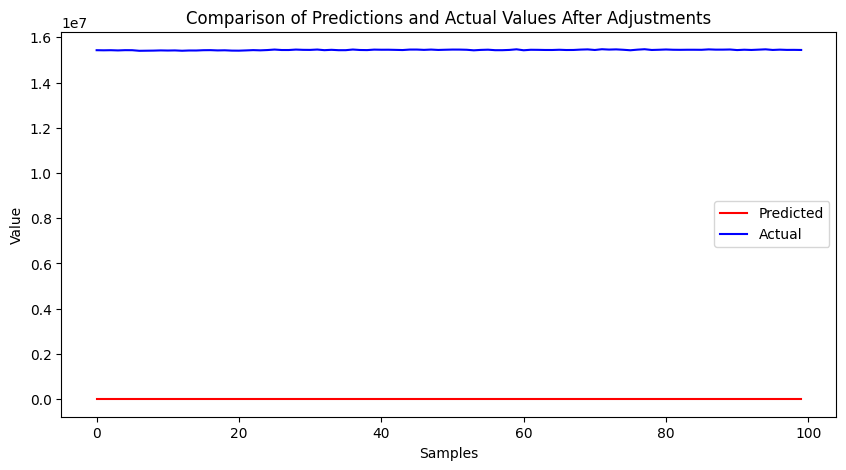

In [ ]:
# Plotting predictions against actual values
actuals = y  # Also reverse log transformation for actual values
plt.figure(figsize=(10, 5))
plt.plot(predictions[:100], 'r-', label='Predicted')
plt.plot(y[:100], 'b-', label='Actual')
plt.title('Comparison of Predictions and Actual Values After Adjustments')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()

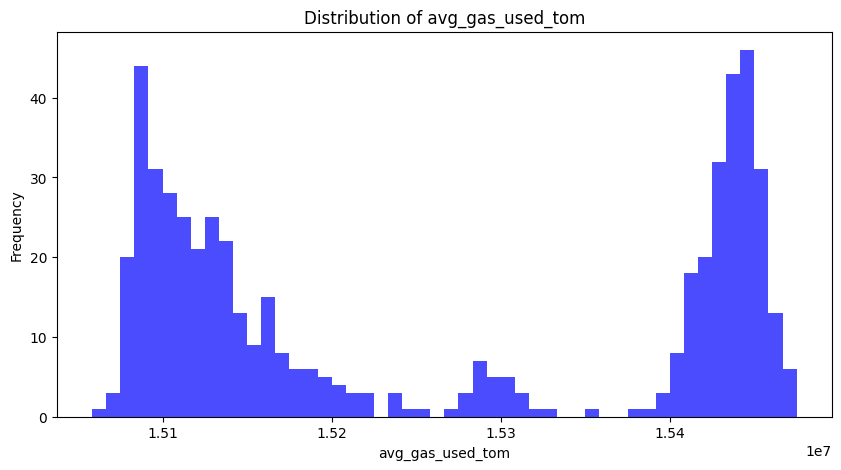

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the target variable
plt.figure(figsize=(10, 5))
plt.hist(df_all['avg_gas_used_tom'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of avg_gas_used_tom')
plt.xlabel('avg_gas_used_tom')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Assuming df_all is loaded and preprocessed appropriately
# Convert 'date_time' to datetime and extract useful features

# Apply log transformation to the target variable to normalize distribution
df_all['log_avg_gas_used_tom'] = np.log1p(df_all['avg_gas_used_tom'])

def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].drop(columns=[target, 'avg_gas_used_tom']).values)  # Ensure to drop the original target
        y.append(data[target].iloc[i])
    return np.array(X), np.array(y)

# Prepare data
X, y = create_sequences(df_all, 'log_avg_gas_used_tom', window_size=7)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_x.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

# Scale the target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim, activation="linear")  # Linear activation to match scaled output
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

embed_dim = X_train_scaled.shape[2]
inputs = Input(shape=(7, embed_dim))
transformer_block = TransformerBlock(embed_dim=embed_dim, num_heads=2, ff_dim=64)
x = transformer_block(inputs)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=20, batch_size=32)

# Predict and inverse transform
predictions_scaled = model.predict(X_val_scaled)
predictions = np.expm1(scaler_y.inverse_transform(predictions_scaled))  # Exponentiate to reverse log transform


Epoch 1/20
14/14 [==============================] - 4s 29ms/step - loss: 1.2903 - val_loss: 0.5474
Epoch 2/20
14/14 [==============================] - 0s 9ms/step - loss: 0.4826 - val_loss: 1.4642
Epoch 3/20
14/14 [==============================] - 0s 9ms/step - loss: 0.3116 - val_loss: 0.4442
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2866 - val_loss: 0.4854
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.2978 - val_loss: 0.1001
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 0.2595 - val_loss: 0.1613
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2143 - val_loss: 0.1900
Epoch 8/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1944 - val_loss: 0.1151
Epoch 9/20
14/14 [==============================] - 0s 9ms/step - loss: 0.1642 - val_loss: 0.1252
Epoch 10/20
14/14 [==============================] - 0s 8ms/step - loss: 0.1591 - val_loss: 0.1566
Epoch 11/20
14/14 

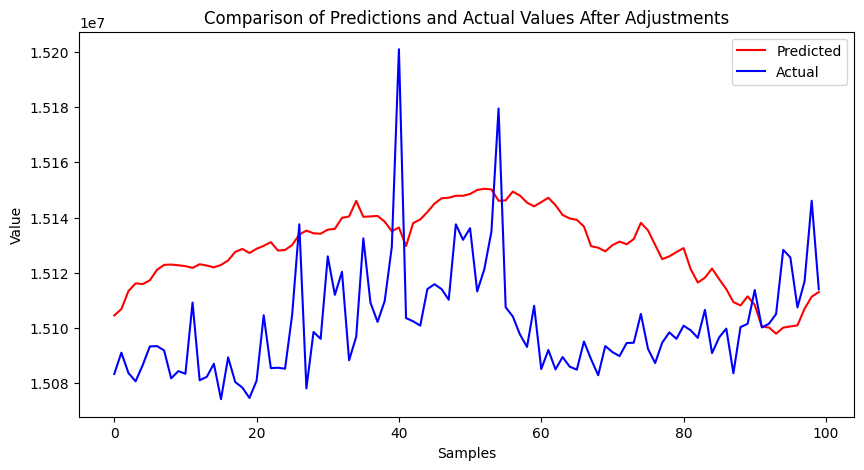

In [ ]:
# Plotting predictions against actual values
actuals = np.expm1(y_val)  # Also reverse log transformation for actual values
plt.figure(figsize=(10, 5))
plt.plot(predictions[:100], 'r-', label='Predicted')
plt.plot(actuals[:100], 'b-', label='Actual')
plt.title('Comparison of Predictions and Actual Values After Adjustments')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Assuming df_all is loaded and preprocessed appropriately
# Apply log transformation to the target variable to normalize distribution
df_all['log_avg_gas_used_tom'] = np.log1p(df_all['avg_gas_used_tom'])

def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].drop(columns=[target, 'avg_gas_used_tom']).values)  # Ensure to drop the original target
        y.append(data[target].iloc[i])
    return np.array(X), np.array(y)

# Prepare data
X, y = create_sequences(df_all, 'log_avg_gas_used_tom', window_size=7)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the features
scaler_x = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_x.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

# Scale the target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

class EnhancedTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)  # Additional attention layer
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(ff_dim, activation="relu"),  # Additional dense layer
            Dense(embed_dim, activation="linear")
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)  # Additional dropout layer

    def call(self, inputs, training=False):
        attn_output1 = self.att1(inputs, inputs)
        attn_output1 = self.dropout1(attn_output1, training=training)
        attn_output2 = self.att2(attn_output1, inputs)  # Chain of attention layers
        attn_output2 = self.dropout2(attn_output2, training=training)
        out1 = self.layernorm1(inputs + attn_output2)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

embed_dim = X_train_scaled.shape[2]
inputs = Input(shape=(7, embed_dim))
transformer_block = EnhancedTransformerBlock(embed_dim=embed_dim, num_heads=2, ff_dim=128)
x = transformer_block(inputs)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation='linear')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=20, batch_size=32)

# Predict and inverse transform
predictions_scaled = model.predict(X_val_scaled)
predictions = np.expm1(scaler_y.inverse_transform(predictions_scaled))  # Exponentiate to reverse log transform

Epoch 1/20
14/14 [==============================] - 6s 34ms/step - loss: 0.5908 - val_loss: 0.2673
Epoch 2/20
14/14 [==============================] - 0s 12ms/step - loss: 0.1611 - val_loss: 0.0120
Epoch 3/20
14/14 [==============================] - 0s 12ms/step - loss: 0.1161 - val_loss: 0.0081
Epoch 4/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0917 - val_loss: 0.0087
Epoch 5/20
14/14 [==============================] - 0s 13ms/step - loss: 0.0667 - val_loss: 0.0078
Epoch 6/20
14/14 [==============================] - 0s 13ms/step - loss: 0.0639 - val_loss: 0.0130
Epoch 7/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0534 - val_loss: 0.0070
Epoch 8/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0476 - val_loss: 0.0071
Epoch 9/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0378 - val_loss: 0.0072
Epoch 10/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0355 - val_loss: 0.0069
Epoch 11/

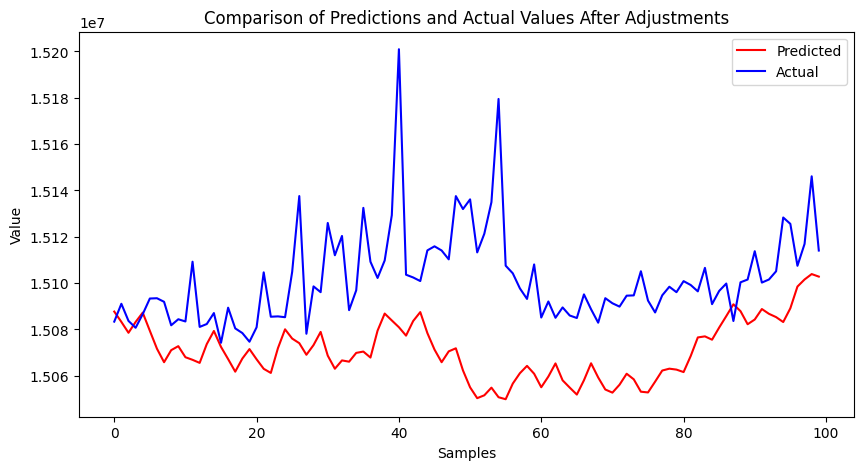

In [ ]:
# Plotting predictions against actual values
actuals = np.expm1(y_val)  # Also reverse log transformation for actual values
plt.figure(figsize=(10, 5))
plt.plot(predictions[:100], 'r-', label='Predicted')
plt.plot(actuals[:100], 'b-', label='Actual')
plt.title('Comparison of Predictions and Actual Values After Adjustments')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
df_all

,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,avg_gas_used_tom,...,TREASURY 20-Yr CMT,Adj Close_eth,Volume_eth,Adj Close_btc,Volume_btc,year,month,day,weekday,log_avg_gas_used_tom
0,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,1.544777e+07,...,2.07,4217.876953,1.599573e+10,63039.824219,31064911614,2021,10,25,0,16.552975
1,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,1.544270e+07,...,2.03,4131.102051,1.715771e+10,60363.792969,34878965587,2021,10,26,1,16.552647
2,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,1.544423e+07,...,1.93,3930.257324,2.621953e+10,58482.386719,43657076893,2021,10,27,2,16.552746
3,67421.642166,3.002487e+07,1.544423e+07,235.721286,282.674664,1.544270e+07,215.997478,1.544893e+07,207.529184,1.544402e+07,...,1.98,4287.318848,2.595815e+10,60622.136719,45257083247,2021,10,28,3,16.552732
4,64129.096891,3.002177e+07,1.544402e+07,228.695509,468.680630,1.544423e+07,235.721286,1.544792e+07,212.211380,1.544558e+07,...,1.98,4414.746582,2.296764e+10,62227.964844,36856881767,2021,10,29,4,16.552834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,157152.837050,2.999968e+07,1.508977e+07,169.080353,308.952772,1.508273e+07,173.852604,1.511023e+07,162.894603,1.510166e+07,...,4.21,2326.524902,1.613725e+10,43997.902344,21028503216,2023,12,22,4,16.530316
542,168868.433772,2.999971e+07,1.509749e+07,156.321339,232.276084,1.509825e+07,155.177878,1.509810e+07,163.901048,1.509850e+07,...,4.20,2231.465332,1.066858e+10,42520.402344,30026850982,2023,12,26,1,16.530106
543,173258.384778,2.999977e+07,1.509850e+07,160.056978,236.451383,1.509749e+07,156.321339,1.509531e+07,161.741618,1.509356e+07,...,4.10,2378.739990,1.416134e+10,43442.855469,25260941032,2023,12,27,2,16.529779
544,150761.920174,2.999976e+07,1.509356e+07,166.317059,257.944678,1.509850e+07,160.056978,1.509686e+07,160.665112,1.508478e+07,...,4.14,2347.566162,1.566080e+10,42627.855469,22992093014,2023,12,28,3,16.529197


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

df_all['date_time'] = pd.to_datetime(df_all['date_time'])

# Function to calculate positional encodings
def positional_encoding(times, dimension):
    pos = (times - times.min()).dt.total_seconds()
    pe = np.zeros((len(times), dimension))
    for i in range(dimension):
        pe[:, i] = np.sin(pos * (10000 ** (-2 * i / dimension)))
    return pe

embed_dim = 16  # Adjust to match the number of features if needed

# Applying positional encoding
pos_enc = positional_encoding(df_all['date_time'], embed_dim)

# Merge positional encoding with the original features and ensure all column names are strings
df_features = df_all.drop(['date_time'], axis=1)
pos_enc_df = pd.DataFrame(pos_enc, index=df_features.index)
df_features = pd.concat([df_features, pos_enc_df], axis=1)
df_features.columns = [str(col) for col in df_features.columns]  # Convert all column names to string


# Create sequences for training data
def create_sequences(data, window_size=7):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i][-1])  # Assuming the target variable is the last column
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# Define the Transformer model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
transformer_block = TransformerBlock(X_train.shape[2], num_heads=2, ff_dim=32)  # embed_dim set to number of features
x = transformer_block(inputs)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)
model.evaluate(X_test, y_test)


Epoch 1/10
11/11 [==============================] - 4s 113ms/step - loss: 2.6863 - val_loss: 1.7320
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 0.6958 - val_loss: 0.3405
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.3833 - val_loss: 0.7719
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.2503 - val_loss: 0.9399
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.2233 - val_loss: 0.4962
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.1637 - val_loss: 0.5859
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.1416 - val_loss: 0.5496
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.1465 - val_loss: 0.4513
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.1444 - val_loss: 0.5771
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0812


0.08121653646230698

4/4 [==============================] - 0s 5ms/step


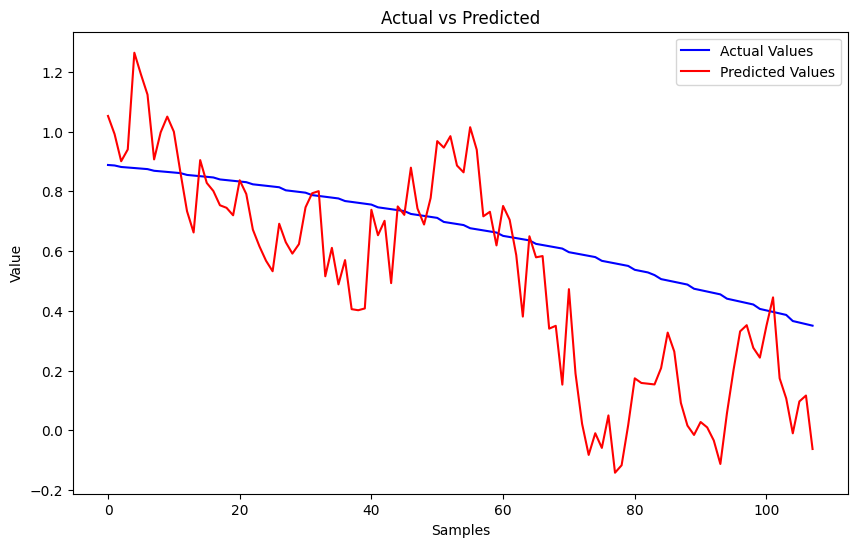

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions
predictions = model.predict(X_test)

# Ensure that y_test and predictions are in the correct shape if necessary
y_test = y_test.flatten()
predictions = predictions.flatten()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

def positional_encoding(times, dimension):
    pos = (times - times.min()).dt.total_seconds()
    pe = np.zeros((len(times), dimension))
    for i in range(dimension):
        pe[:, i] = np.sin(pos * (10000 ** (-2 * i / dimension)))
    return pe

def create_sequences(data, window_size=7):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])  # All columns except the last one
        y.append(data[i + window_size, -1])   # Last column is the target
    return np.array(X), np.array(y)

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


df_all['date_time'] = pd.to_datetime(df_all['date_time'])

embed_dim = 16  # Set embedding dimension, adjust based on your model architecture

# Apply positional encoding
pos_enc = positional_encoding(df_all['date_time'], embed_dim)  # Adjust this as necessary
df_all.drop('date_time', axis=1, inplace=True)
df_all = pd.concat([df_all, pd.DataFrame(pos_enc, index=df_all.index)], axis=1)

# Split data into features and target
X = df_all.iloc[:, :-1].values
y = df_all.iloc[:, -1].values  # Assuming the target is the last column
data = np.column_stack((X, y))

# Create sequences
window_size = 7
X, y = create_sequences(data, window_size)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Define the Transformer model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
transformer_block = TransformerBlock(embed_dim, num_heads=2, ff_dim=32)
x = transformer_block(inputs)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Evaluate the model and plot results
predictions = model.predict(X_test).flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel ('Value')
plt.legend()
plt.show


ValueError: Exception encountered when calling layer "transformer_block_5" (type TransformerBlock).

in user code:

    File "<ipython-input-35-fbf3caa5ed0d>", line 44, in call  *
        return self.layernorm2(out1 + ffn_output)

    ValueError: Dimensions must be equal, but are 31 and 16 for '{{node transformer_block_5/add_1}} = AddV2[T=DT_FLOAT](transformer_block_5/layer_normalization_10/batchnorm/add_1, transformer_block_5/dropout_12/Identity)' with input shapes: [?,7,31], [?,7,16].


Call arguments received by layer "transformer_block_5" (type TransformerBlock):
  • inputs=tf.Tensor(shape=(None, 7, 31), dtype=float32)
  • training=False